# **Motivação**
As **doenças cardiovasculares (DCVs)** são as principais causa de morte global, responsáveis por 32% de todas as mortes no mundo.
Quatro em cada cinco mortes por DVCS são causadas por ataques cardíacos e acidentes vasculares cerebrais(AVCs).
estima-se que 19,8 milhões de pessoas morreram de doenças cardiovasculares em 2022.

[Fonte](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds))

# **Objetivo**
Desenvolver um modelo de machine learning capaz de prever a ocorrência de uma possível doença cardíaca ou insuficiência cardíaca.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [34]:
url = "https://raw.githubusercontent.com/Rafinha003/Doenca_Coracao/main/heart.csv"
df = pd.read_csv(url)

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Variáveis

**Age:** Idade do paciente.

**Sex:** Sexo do paciente (`M` ou `F`).

**ChestPainType:** Tipo de dor torácica:
- **TA (Angina Típica):** Dor no peito clássica.
- **ATA (Angina Atípica):** Dor no peito com algumas características de angina.
- **NAP (Dor Não Anginosa):** Dor no peito de origem não cardíaca (ex: problemas gastrointestinais).
- **ASY (Assintomático):** Paciente não sente dor no peito.

**RestingBP** Frequência cardíaca em repouso

**Cholesterol:** Colesterol total no sangue.

**FastingBS:** Glicose no sangue em jejum.

**RestingECG:** Resultado do eletrocardiograma:
- **Normal:** Ritmo e traçado cardíaco normais.
- **ST:** Indica possível problema cardíaco.
- **LVH:** Sugere espessamento da parede do ventrículo esquerdo.

**MaxHR:** Frequência cardíaca máxima alcançada.

**ExerciseAngina:** Presença de angina durante exercício:
- **Y:** Paciente relatou dor no peito.
- **N:** Paciente não relatou dor no peito.

**Oldpeak:** Medida numérica que reflete o quanto o músculo cardíaco ficou estressado e desabastecido de oxigênio durante o exercício.

**ST_Slope:** Inclinação do segmento ST:
- **Upsloping (Up):** O segmento ST desce, mas sobe imediatamente.
- **Flat:** O segmento ST desce e permanece plano.
- **Downsloping (Down):** O segmento ST desce e continua caindo.

**HeartDisease:** Indicador de doença cardíaca:
- **1:** Paciente possui doença cardíaca.
- **0:** Paciente não possui doença cardíaca.


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [36]:
df.duplicated().sum()

np.int64(0)

### Observação:
Foram encontradas variáveis categóricas nominais: **Sex**, **ChestPainType**, **RestingECG**, **ExerciseAngina** e **ST_Slope**.

Antes do treinamento do modelo, será necessário realizar **codificação (Encoding)** dessas variáveis para transformá-las em valores numéricos, pois os algoritmos de machine learning não trabalham diretamente com dados categóricos.


O Dataset não possui nenhum dado null

Após a verificação de registros duplicados, constatou-se que **não existem linhas repetidas** no dataset.  
Isso indica que **cada observação corresponde a um paciente distinto**, garantindo a integridade dos dados.


In [37]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Observação:

- **RestingBP:** Apresenta valor mínimo igual a **0**, o que é **clinicamente impossível** (exceto em caso de óbito).  
  Isso indica um **forte indício de que os valores iguais a zero estão sendo utilizados para representar dados faltantes**.

- **Cholesterol:** Também apresenta valor mínimo igual a **0**, o que é **clinicamente impossível**.  
  Portanto, há **indício de que os valores zeros foram utilizados para preencher valores ausentes (missing values)**.


In [38]:
for col in ['RestingBP', 'Cholesterol']:
    median_value = df.loc[df[col] != 0, col].median()

    df[col] = df[col].replace(0, median_value)

### Tratamento de valores inválidos:
Foram substituídos os valores **0** nas colunas **RestingBP** e **Cholesterol** pela **mediana** de cada respectiva coluna.  
Essa substituição foi realizada porque valores iguais a zero são **clinicamente impossíveis**, indicando possivelmente a presença de **dados ausentes mascarados**.


<Axes: >

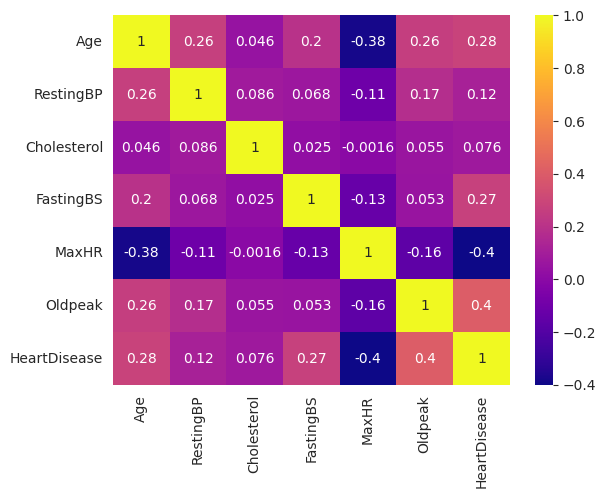

In [39]:
sns.set_style('darkgrid')
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='plasma')

## Análise da Correlação

- **Oldpeak:** Apresenta a **correlação positiva mais forte** com a variável-alvo (*HeartDisease*).  
  Isso faz sentido, pois representa o quanto o músculo cardíaco ficou **estressado e desabastecido de oxigênio durante o exercício**, o que está diretamente relacionado à presença de doença cardíaca.

- **MaxHR:** Apresenta a **correlação negativa mais forte** com *HeartDisease*.  
  O sinal negativo indica que **quanto menor o valor de MaxHR, maior a probabilidade de HeartDisease = 1**.  
  Esse comportamento é consistente com o conceito de **incompetência cronotrópica**, isto é, a **incapacidade do coração de aumentar adequadamente a frequência cardíaca durante o esforço**, um forte indicativo de disfunção cardíaca.


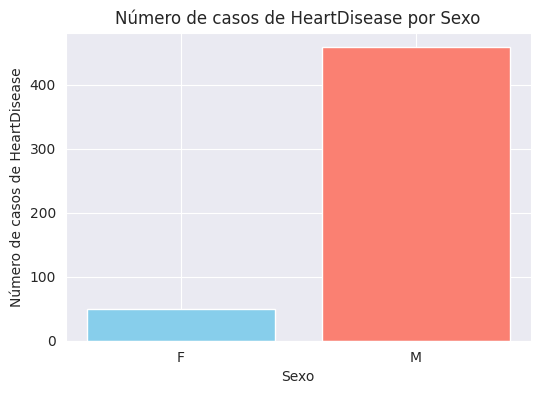

In [40]:
heart_by_sex = df.groupby('Sex')['HeartDisease'].sum()

plt.figure(figsize=(6,4))
plt.bar(heart_by_sex.index, heart_by_sex.values, color=['skyblue', 'salmon'])
plt.xlabel('Sexo')
plt.ylabel('Número de casos de HeartDisease')
plt.title('Número de casos de HeartDisease por Sexo')
plt.show()

In [41]:
df['Sex'].value_counts()

,count
Sex,
M,725
F,193


### Número de casos de HeartDisease por Sexo

- **Número absoluto de casos de HeartDisease = 1:**  
  Os **homens apresentam mais casos** que as mulheres.

- **Distribuição da base de dados:**  
  Há uma **grande desproporção de gêneros na amostra**, com **795 homens** e **193 mulheres**.

 **Observação:**  
Essa desproporção pode influenciar nosso modelo, fazendo com que ele **tenda a classificar homens como HeartDisease = 1**.  
Para evitar esse viés, **será realizado futuramente um tratamento da amostragem**, garantindo um equilíbrio mais adequado entre os gêneros.


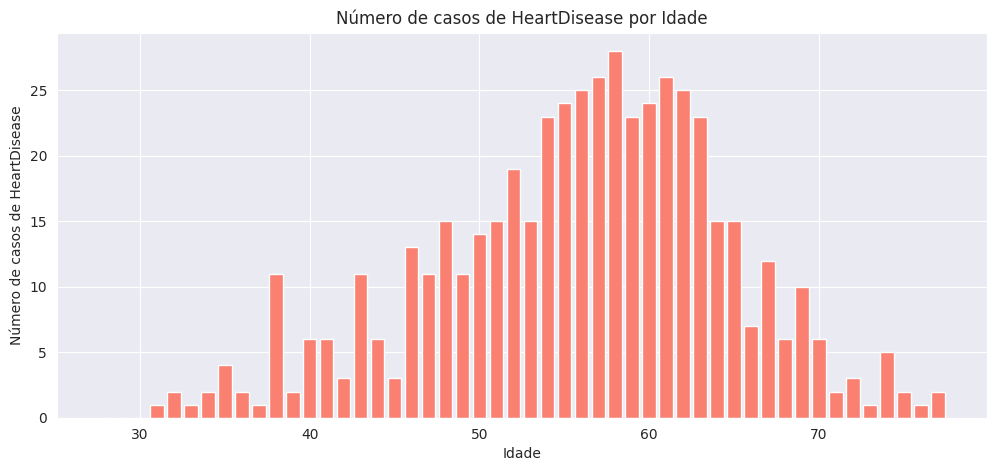

In [42]:
heart_by_age = df.groupby('Age')['HeartDisease'].sum()

plt.figure(figsize=(12,5))
plt.bar(heart_by_age.index, heart_by_age.values, color='salmon')
plt.xlabel('Idade')
plt.ylabel('Número de casos de HeartDisease')
plt.title('Número de casos de HeartDisease por Idade')
plt.show()

### Análise do número de casos de HeartDisease por idade

- A **faixa etária com maior número de ocorrências** está entre **53 e 63 anos**.  
- O **aumento nos casos** começa a ser mais evidente a partir dos **48-50 anos**.


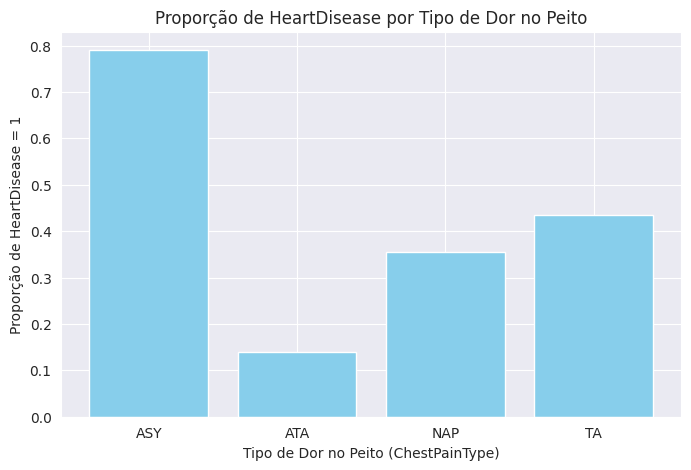

In [43]:
prop_chestpain = df.groupby('ChestPainType')['HeartDisease'].mean()


plt.figure(figsize=(8,5))
plt.bar(prop_chestpain.index, prop_chestpain.values, color='skyblue')
plt.xlabel('Tipo de Dor no Peito (ChestPainType)')
plt.ylabel('Proporção de HeartDisease = 1')
plt.title('Proporção de HeartDisease por Tipo de Dor no Peito')
plt.show()

### Proporção de HeartDisease por tipo de dor no peito

No dataset, **78% dos pacientes com HeartDisease são do tipo ASY (Assintomático)**, ou seja, **não apresentam dor no peito**, mas sofrem de **isquemia silenciosa**.  



[Perigos ocultos da isquemia silenciosa](https://cvrti.utah.edu/the-silent-threat-unraveling-the-hidden-dangers-of-silent-cardiac-ischemia/)

In [44]:
colunas_categoricas = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Separando as colunas categoricas para aplicar o **One-Hot Encoding** com o objetivo de transformar essas colunas no formato númerico, para que possa ser compreendido e utilizado por modelos de machine Learning

In [45]:
df_encoded = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


### Como foi aplicado
Foi criado novas colunas binárias(false, true) que representam cada categoria possiível dessas variáveis

In [46]:
X = df_encoded.drop('HeartDisease', axis=1)
Y = df_encoded['HeartDisease']

**X (features):** Conjunto de variáveis independentes utilizadas pelo modelo para realizar as previsões.

**y (target):** A variável dependente que o modelo busca prever com base nas features.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y)

In [48]:
print(f"\nDimensões dos Dados:")
print(f"X_train (Treino de Features): {X_train.shape}")
print(f"X_test (Teste de Features):   {X_test.shape}")
print(f"y_train (Treino de Target):   {y_train.shape}")
print(f"y_test (Teste de Target):     {y_test.shape}")


Dimensões dos Dados:
X_train (Treino de Features): (734, 15)
X_test (Teste de Features):   (184, 15)
y_train (Treino de Target):   (734,)
y_test (Teste de Target):     (184,)


**test_size=0.2:** define que 20% dos dados serão destinados ao conjunto de teste e 80% ao de treino.

**random_state=42:** define uma semente aleatória fixa, garantindo que a divisão seja reprodutível (mesma separação a cada execução).

**stratify=Y:** mantém a proporção das classes da variável Y nos dois conjuntos, evitando desequilíbrio entre treino e teste.

In [49]:
print("Distribuição do target antes do SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nDistribuição do target após o SMOTE:")
print(Counter(y_train_res))

Distribuição do target antes do SMOTE:
Counter({1: 406, 0: 328})

Distribuição do target após o SMOTE:
Counter({1: 406, 0: 406})


### Balanceamento das Classes com SMOTE

O método SMOTE, é uma técnica para lidar com conjuntos de dados desbalanceados, ela gera novas instâncias sintéticas da classe minoritária, para que equilibre a distribuição de classes.

#### O que seria instância  sintética?
É um novo exemplo de dados criado artificialmente a aprtir de exemplos reais da classe minoritária.

#### Como que funciona?
*   Ele analisa os vizinhos mais próximos de cada amostra da classe minoritária.
*   Gera um novo ponto interpolado entre a amostra original e um de seus vizinhos.

#### Porque aplicado apenas no treino?
O conjunto de teste não se deve ser alterado, pois ele representa dados reais e serve para avaliar o modelo de forma justa, sem influência dos dados sitéticos.




In [50]:
arvore_decisao_modelo = DecisionTreeClassifier(random_state=42)

Foi desenvolvido um modelo de **Árvore de Decisão** com o objetivo de prever a ocorrência de uma possível doença cardíaca

In [51]:
arvore_decisao_modelo.fit(X_train_res, y_train_res)

DecisionTreeClassifier(random_state=42)

treinando o modelo  utilizando os dados de treino balanceados

In [52]:
predicao_teste_modelo = arvore_decisao_modelo.predict(X_test)

print("\n--- Relatório de Classificação da Árvore de Decisão (Teste) ---")
print(classification_report(y_test, predicao_teste_modelo))


--- Relatório de Classificação da Árvore de Decisão (Teste) ---
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        82
           1       0.81      0.77      0.79       102

    accuracy                           0.78       184
   macro avg       0.78      0.78      0.78       184
weighted avg       0.78      0.78      0.78       184



In [53]:
Acuracia = accuracy_score(y_test, predicao_teste_modelo)
print(f"Acurácia Geral: {accuracy:.4f}")

Acurácia Geral: 0.7772


**precision (precisão)**
Classe 0 → 0.74 → 74% das previsões de “0” estavam certas

Classe 1 → 0.81 → 81% das previsões de “1” estavam certas

**recall (revocação / sensibilidade)**

Classe 0 → 0.78 → o modelo identificou corretamente 78% dos casos reais da classe 0

Classe 1 → 0.77 → identificou 77% dos casos reais da classe 1

**f1-score**

Média harmônica entre precisão e recall — um equilíbrio entre os dois.

Classe 0 → 0.76

Classe 1 → 0.79

Quanto mais próximo de 1, melhor o desempenho.

**accuracy (acurácia geral):**
O modelo acertou 77,7% das previsões do conjunto de teste, signficando que o **modelo previu corretamente cerca de 3 em cada 4 casos**

In [54]:
conf_matrix = confusion_matrix(y_test, predicao_teste_modelo)
print("\nMatriz de Confusão:")
print(conf_matrix)


Matriz de Confusão:
[[64 18]
 [23 79]]


## Matriz de confusão:
Acertou 64 pacientes saudáveis (verdadeiros negativos)

Acertou 79 pacientes doentes (verdadeiros positivos)

Errou 18 pacientes saudáveis, classificando-os como doentes (falsos positivos)

Errou 23 pacientes doentes, classificando-os como saudáveis (falsos negativos)